#Descrizione

Modello su database da 18k; rete neurale vanilla (shallow).

Parametri:

1.   2 layer da 141 nodi, 94 nodi;
2.   Immagini 64x64 (flattened dal primo layer, 0-padded/troncate);
3.   1024 batch size;
4.   Accuratezza finale: 
     * GPU: 90% - 83% - 80% - 80%.
     * CPU: 81% - 82% - 80% - 82%.

(Patience = 10).


In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


#Import

In [2]:
import tensorflow as tf
from tensorflow import keras as ks

import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from skimage.transform import resize

import cv2

#Data visualization
import seaborn as sns

from matplotlib import pyplot as plt

import glob
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os, os.path

#Per modello NN
from tensorflow.keras import layers
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import CuDNNLSTM
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import ConvLSTM2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Softmax
from tensorflow.keras.layers import Dropout

import time
import math

print(tf.__version__)

1.15.2


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


##Defining methods

In [3]:
#Extract the class from the file name, if the class is the string before che -
def extract_label(from_string):
  position = from_string.index('-') # gets position of the - in the filename
  substring = from_string[0:position]
  return substring

def extract_obf(from_string):
  start_pos = from_string.index('-')
  end_pos = from_string.index('.')
  substring = from_string[(start_pos + 1):end_pos]
  return substring

def mapping_labels_encoded(label_encoder):
  for index in range(len(list(label_encoder.classes_))):
    print(index, end = "-> ")
    print(list(label_encoder.inverse_transform([index]))) 

class TimeHistory(ks.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(predicted_label,
                                100*np.max(predictions_array),
                                true_label),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')


print("Done")

Done


#Import database

In [4]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [5]:
downloaded = drive.CreateFile({'id':"18ESID3MpwG-SzZPE1EENzsGPh8vl8ti9"})   # replace the id with id of file you want to access
downloaded.GetContentFile('data_18800.zip')        # replace the file name with your file

In [6]:
!unzip -q data_18800.zip -d DB_Repo/

print("Done")

Done


In [7]:
path, dirs, files = next(os.walk("/content/DB_Repo/data"))
file_count = len(files)
#Should be 18800
print(file_count)

18800


In [8]:
%cd /content/DB_Repo/data
!pwd

/content/DB_Repo/data
/content/DB_Repo/data


#Lettura database, resize immagini e modello

In [9]:
##PARAMETERS

batch_size = 1024

#Unit in first layer
num_units1 = 141
num_units2 = 94

new_dim = 64
MAX_LEN = 64 #fisso
channels = 1

time_steps = new_dim
n_features = MAX_LEN
#size_ts_blocks = 8

n_epochs = 100

#Considero il primo 20% della lista di dati come test set
test_percentage = 20 #%
#Considero il 20% della lista di dati - esclusi i dati di test - come validation set
validation_percentage = 20 #%

In [10]:
#COSTANTI E DICHIARAZIONI

database_list = list()
labels_list = list()
obf_list = list()

In [11]:
#LETTURA E RESIZE IMMAGINI

print("START IMAGE INPUT")
#Aggiungo i valori alle liste leggendo i vari files
for filename in glob.glob('*.npy'):
  temp_img = np.load(filename)
  temp_img = temp_img.reshape((-1, MAX_LEN)).astype('float32') 
  dimStrana, _ = temp_img.shape
  #print("prima: ", temp_img.shape)
  if dimStrana <= 64:
    temp_img = np.pad(temp_img, ((0, 64 - dimStrana),(0,0)), mode='constant',constant_values=0)
  elif dimStrana > 64:
    temp_img = temp_img[0:64, 0:64]
  else:
    print("ERROR")
    quit()
  #print("dopo: ", temp_img.shape)
  #temp_img = cv2.resize(temp_img, (MAX_LEN, new_dim), interpolation=cv2.INTER_CUBIC)
  database_list.append(temp_img)
  #Salvo la label, ossia la classe
  labels_list.append(extract_label(filename))
  #Salvo la lista di offuscatori di ogni file
  obf_list.append(extract_obf(filename))
print("END IMAGE INPUT")

START IMAGE INPUT
END IMAGE INPUT


In [12]:
#SHUFFLE

#Ho i valori e le etichette in due liste (+ obf); 
#le mescolo mantenendo l'ordine tra valore-label
temp = list(zip(database_list, labels_list, obf_list))
np.random.shuffle(temp)
database_list, labels_list, obf_list = zip(*temp)

In [13]:
#SUDDIVISIONE DATI
#Suddivido in training set, test set e validation test
assert len(database_list) == len(labels_list) == len(obf_list)
print(len(database_list))

#Split per creare test set
index_to_split = math.ceil((len(database_list) * test_percentage) / 100)
indices = [(0, index_to_split - 1), (index_to_split, len(database_list) - 1)]

test_list, training_list = [database_list[s:e+1] for s,e in indices]
labels_test_list, labels_training_list = [labels_list[s:e+1] for s,e in indices]
obf_test_list, obf_training_list = [obf_list[s:e+1] for s,e in indices]

#Split per creare validation set
index_to_split = math.ceil((len(training_list) * validation_percentage) / 100)
indices = [(0, index_to_split - 1), (index_to_split, len(training_list) - 1)]

validation_list, training_list = [training_list[s:e+1] for s,e in indices]
labels_validation_list, labels_training_list = [labels_training_list[s:e+1] for s,e in indices]
obf_validation_list, obf_training_list = [obf_training_list[s:e+1] for s,e in indices]

18800


In [14]:
#Trasformo i valori in numpy.ndarray
train_images = np.array(training_list)
test_images = np.array(test_list)
validation_images = np.array(validation_list)

train_labels = np.array(labels_training_list)
test_labels = np.array(labels_test_list)
validation_labels = np.array(labels_validation_list)

train_obf = np.array(obf_training_list)
test_obf = np.array(obf_test_list)
validation_obf = np.array(obf_validation_list)

In [15]:
#Encoding delle labels;
#Se nella suddivisione il 100% di una classe è fuori dal train_labels,
#Vi sarà un errore nell'encoding delle labels negli altri set.
label_encoder = LabelEncoder()
label_encoder.fit(train_labels)
train_labels_encoded = label_encoder.transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)
validation_labels_encoded = label_encoder.transform(validation_labels)

In [16]:
#Normalizzazione valori in range 0-1
train_images = train_images / 65535.0
test_images = test_images / 65535.0
validation_images = validation_images / 65535.0

In [17]:
#Dichiarazione altri parametri
n_classes = len(list(label_encoder.classes_))

#Definizione modello di rete neurale

In [18]:
modelLSTM = ks.Sequential()

#Batch size should be (at most) the same number of hidden cells
#no activation selection

modelLSTM.add(Flatten())
modelLSTM.add(tf.keras.layers.Dense(num_units1))
modelLSTM.add(tf.keras.layers.Dense(num_units2))
modelLSTM.add(Dense(n_classes, activation='softmax'))

modelLSTM.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#Definizione callback
es = ks.callbacks.EarlyStopping(monitor='val_loss', patience=10,
                                mode='auto', restore_best_weights=True, verbose=0)
time_callback = TimeHistory()

#Validation_data è usato al termine di ogni epoch;
hist = modelLSTM.fit(train_images, train_labels_encoded, 
                    batch_size = batch_size,
                    validation_data=(test_images, test_labels_encoded), 
                    epochs=n_epochs, shuffle='true',
                    callbacks=[time_callback, es], verbose=1)

number_of_epochs_it_ran = len(hist.history['loss'])

time_per_epoch = time_callback.times
total_time = sum(time_per_epoch)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 12032 samples, validate on 3760 samples
Epoch 1/100
12032/12032 [==============================] - 2s 134us/sample - loss: 5.0208 - acc: 0.0584 - val_loss: 4.2306 - val_acc: 0.1247
Epoch 2/100
12032/12032 [==============================] - 1s 101us/sample - loss: 3.7529 - acc: 0.1867 - val_loss: 3.2699 - val_acc: 0.2247
Epoch 3/100
12032/12032 [==============================] - 1s 103us/sample - loss: 2.9587 - acc: 0.2910 - val_loss: 2.8092 - val_acc: 0.3112
Epoch 4/100
12032/12032 [==============================] - 1s 105us/sample - loss: 2.5503 - acc: 0.3947 - val_loss: 2.5304 - val_acc: 0.3923
Epoch 5/100
12032/12032 [==============================] - 1s 102us/sample - loss: 2.2904 - acc: 0.4705 - val_loss: 2.3165 - val_acc: 0.4614
Epoch 6/100
12032/12032 [==============================] - 1s 101us/sample - loss: 2.0925 - acc: 0.5301 - val_loss: 2.1664 - val_acc: 0.4992
Epoch 7/100
12032/12032 

In [19]:
test_accuracy = modelLSTM.evaluate(validation_images, validation_labels_encoded)

3008/3008 [==============================] - 0s 87us/sample - loss: 0.8080 - acc: 0.8411


In [20]:
print(total_time)

116.3775372505188


#Risultati modello

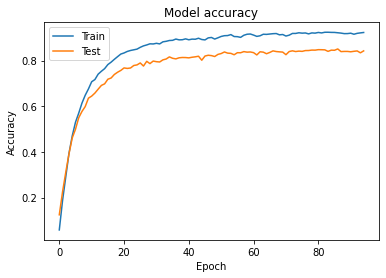

In [21]:
#Plot training & validation accuracy values
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

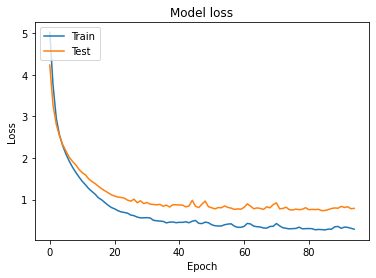

In [22]:
# Plot training & validation loss values
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

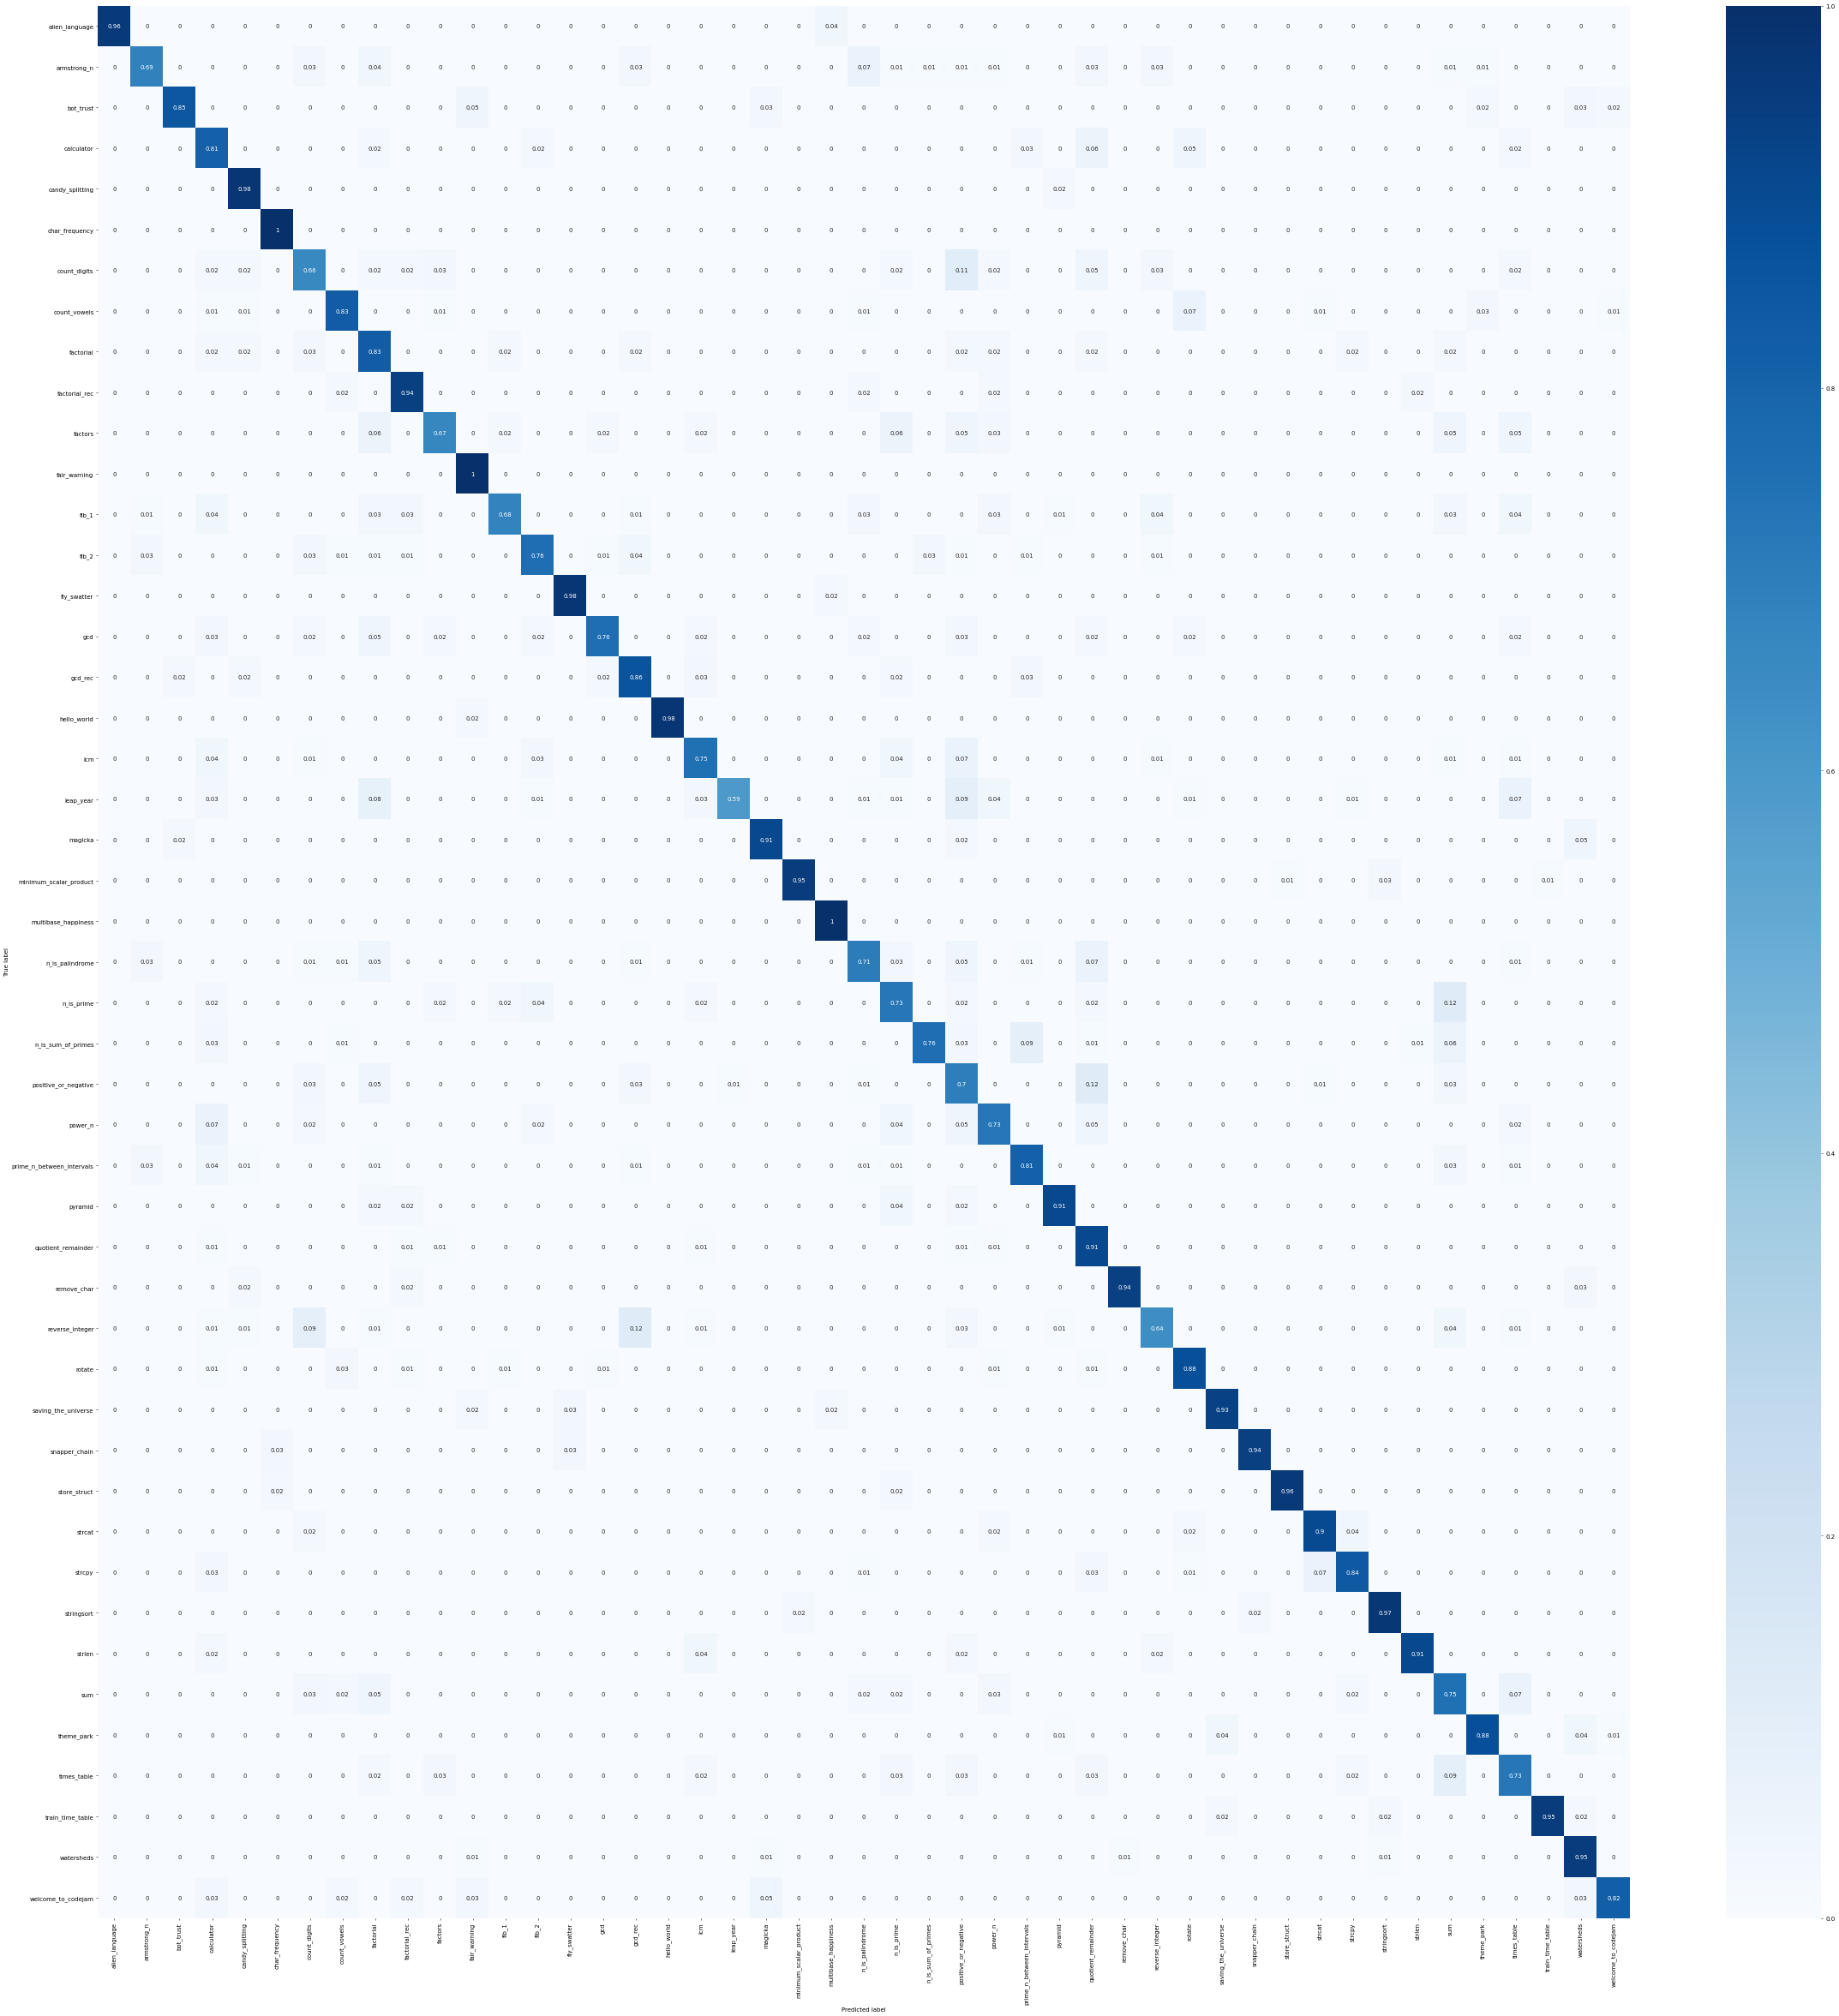

In [23]:
#Necessito di un array con tutte le labels
validation_predictions = modelLSTM.predict_classes(validation_images)

conf_matr = confusion_matrix(y_true = validation_labels_encoded, y_pred = validation_predictions)
#print(conf_matr)

con_mat_norm = np.around(conf_matr.astype('float') / conf_matr.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                        index = list(label_encoder.classes_), 
                        columns = list(label_encoder.classes_))

figure = plt.figure(figsize=(len(list(label_encoder.classes_)), len(list(label_encoder.classes_))), dpi=50)
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

#Analisi degli errori di classificazione

In [24]:
incorrects = np.nonzero(modelLSTM.predict_classes(validation_images) != validation_labels_encoded)
#Salvo in incorrects l'array di tutti gli elementi mal predetti
#Altra rappresentazione di incorrects
#incorrects = np.nonzero(modelLSTM.predict_classes(validation_images).reshape((-1,)) != validation_labels_encoded)

temp_incorrects = list()
for elem in incorrects[0]:
  #print(elem)
  temp_incorrects.append(elem)
incorrects = temp_incorrects
#Manipolo l'array delle previsioni scorrette affinchè sia una lista di valori
#Ogni valore è un numero, che indica il file del test_images sbagliato,
#Ossia ogni numero in incorrects è una classe mal indovinata

In [25]:
#print(incorrects)

In [26]:
wrong_labels_str = list()
#wrong_labels = list()
wrong_obf = list()
for elem in incorrects:
  '''
  Ogni elemento in incorrects, ossia ogni elem, è un numero.
  Tale numero indica quegli indici FALLITI all'interno del test set (test_labels_encoded).
  E' quindi un array di numeri, 3, 7, 9 ecc, ed ogni numero indica il file che ha fallito la previsione.

  Se 3, indica che il file 3 in test_labels_encoded ha FALLITO la previsione.
  Prelevo quel file da test_labels_encoded; se 3, test_labels_encoded[3] ritorna un intero,
  ossia l'encode della label corrispondente.
  '''
  string_to_append = str(label_encoder.inverse_transform([validation_labels_encoded[elem]]))
  wrong_labels_str.append(string_to_append)
  #wrong_labels.append(test_labels_encoded[elem])
  ##########
  '''
  Al riguardo della lista degli offuscamenti, è più semplice.
  Se incorrects è una lista di previsioni fallite riportando l'indice della label,
  quell'indice, in obf_list, ritorna la lista corrispondente di offuscamenti.
  '''
  wrong_obf.append(validation_obf[elem])

In [27]:
print(len(wrong_labels_str))
print(len(wrong_obf))

assert len(wrong_labels_str) == len (wrong_obf)

478
478


In [28]:
#Genero la lista di set di offuscamenti errati, senza badare all'ordine
#in cui gli offuscamenti sono stati applicati

set_obfs = list()

for elem in wrong_obf:
  temp_list = elem.split('-')
  
  temp_list.sort()
  separator = '-'
  temp_list = separator.join(temp_list)
  set_obfs.append(temp_list)

In [29]:
#Genero la lista di set di offuscamenti errati;
#conto ogni singolo offuscamento che compare nelle
#trasformazioni d'offuscamento.

single_obf = list()

for elem in wrong_obf:
  temp_list = elem.split('-')

  for sub_elem in temp_list:
    single_obf.append(sub_elem)

In [30]:
from collections import Counter

count_labels_err = Counter(wrong_labels_str)
count_obf_err = Counter(wrong_obf)
count_set_obfs = Counter(set_obfs)

count_single_obf = Counter(single_obf)

##Stampo grafi rappresentanti gli errori di previsione

### **Stampa per lista offuscamenti erronea**

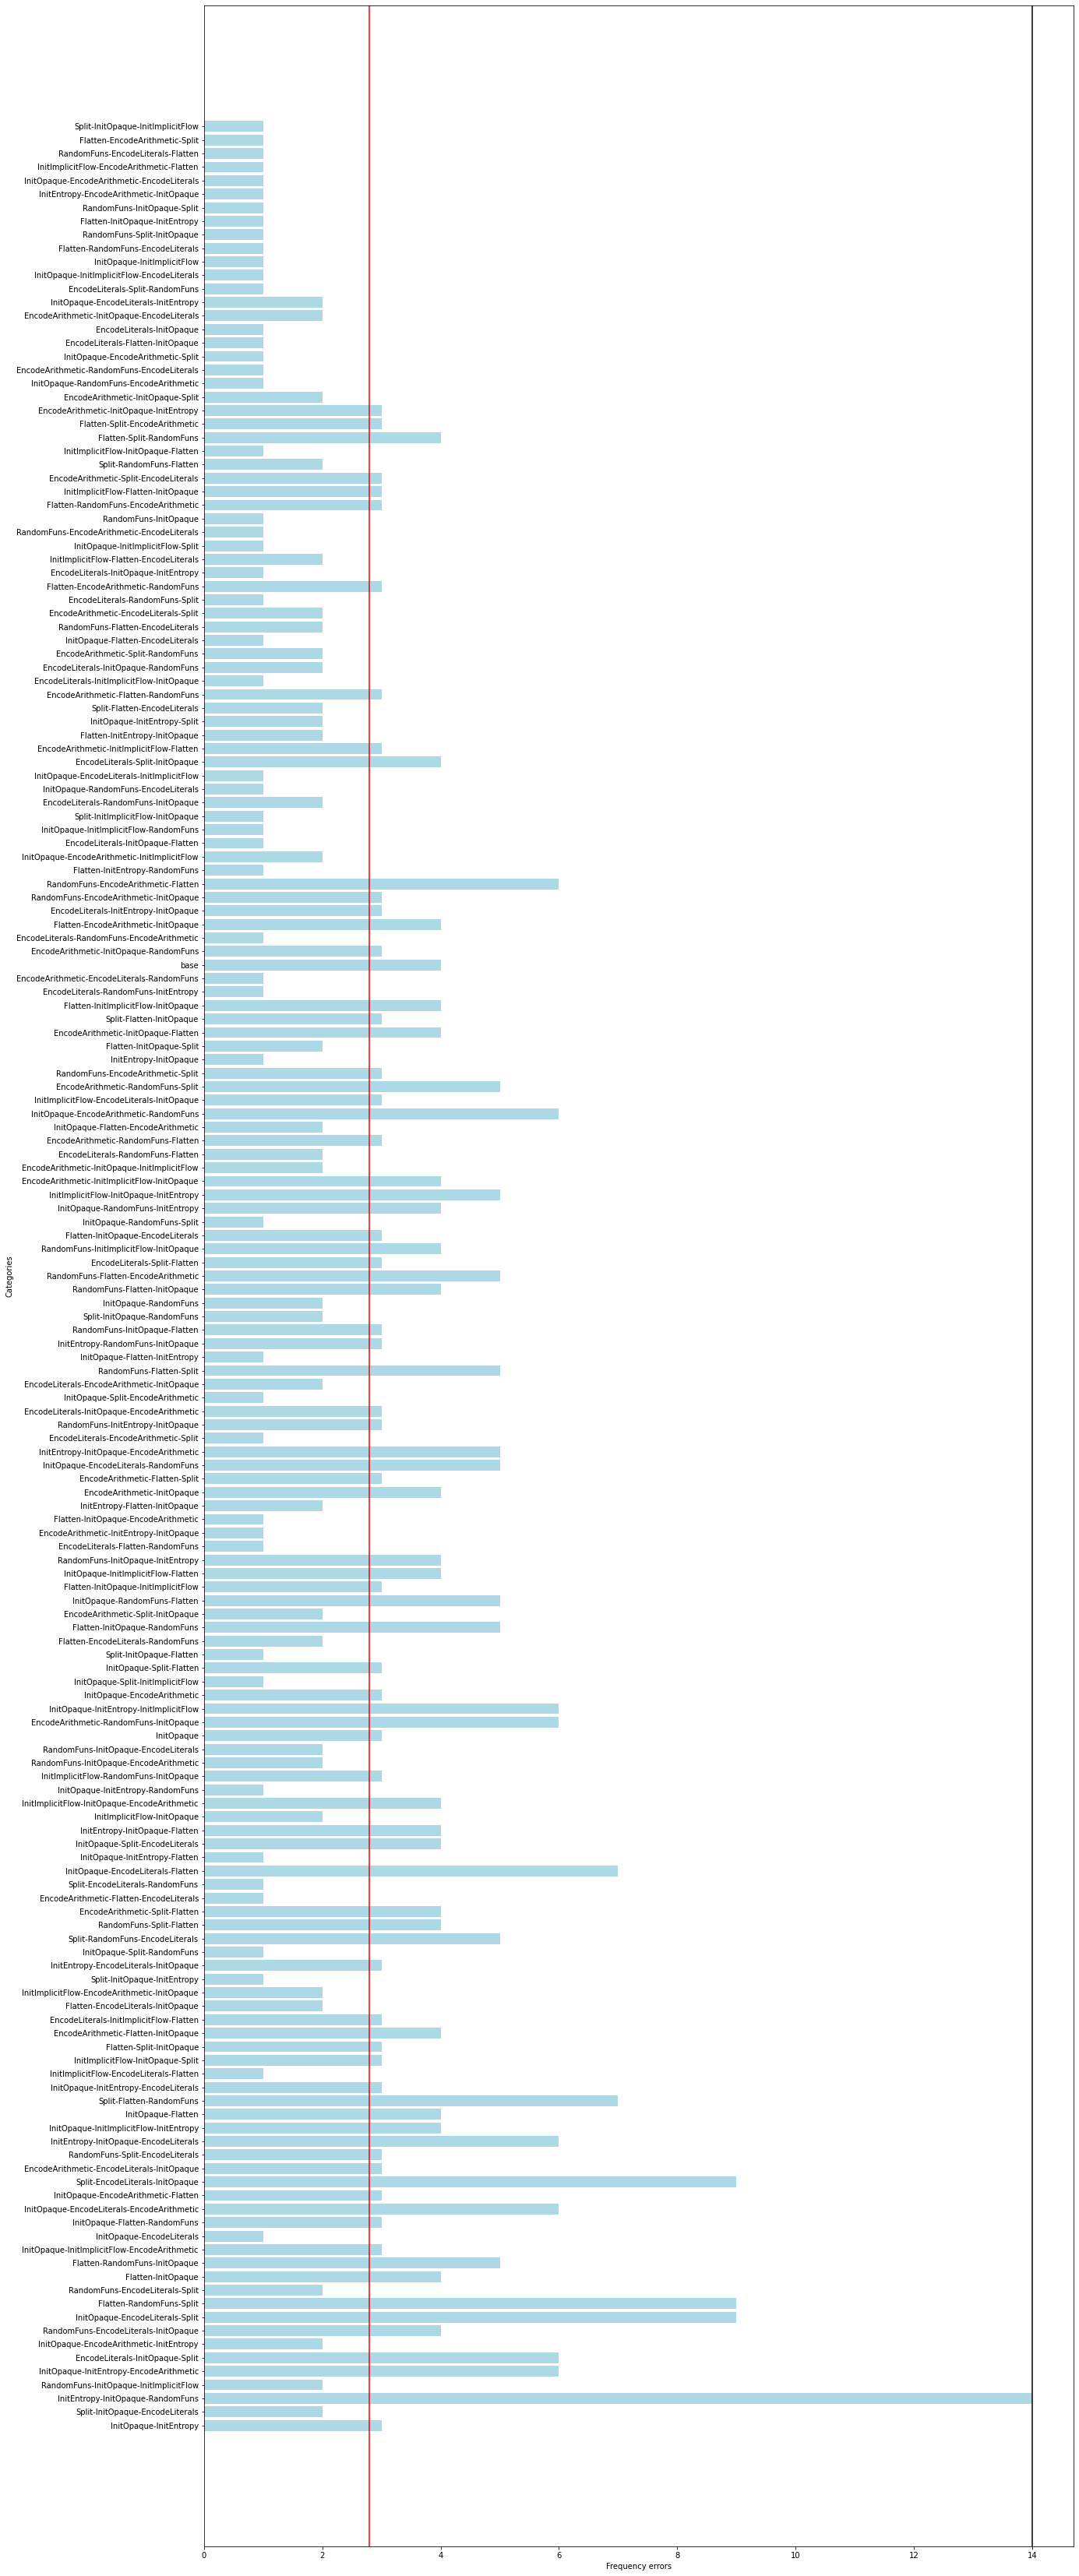

In [31]:
plt.figure(figsize=(20, 60))

plt.barh(list(count_obf_err.keys()), list(count_obf_err.values()), color="lightblue")

plt.axvline(np.asarray(list(count_obf_err.values())).mean(), color="red") # Horizontal line adding the threshold
#plt.axvline(np.asarray(list(count_obf_err.values())).std(), color="grey") # Horizontal line adding the threshold
plt.axvline(np.asarray(list(count_obf_err.values())).max(), color="black") # Horizontal line adding the threshold

plt.xlabel("Frequency errors") # x label
plt.ylabel("Categories") # y label
plt.show()

### **Stampa degli errori in base alle trasformazioni d'offuscamento applicate**

In qualsiasi loro ordine (ossia A-B-C e B-C-A conta come 2 errori per A-B-C).

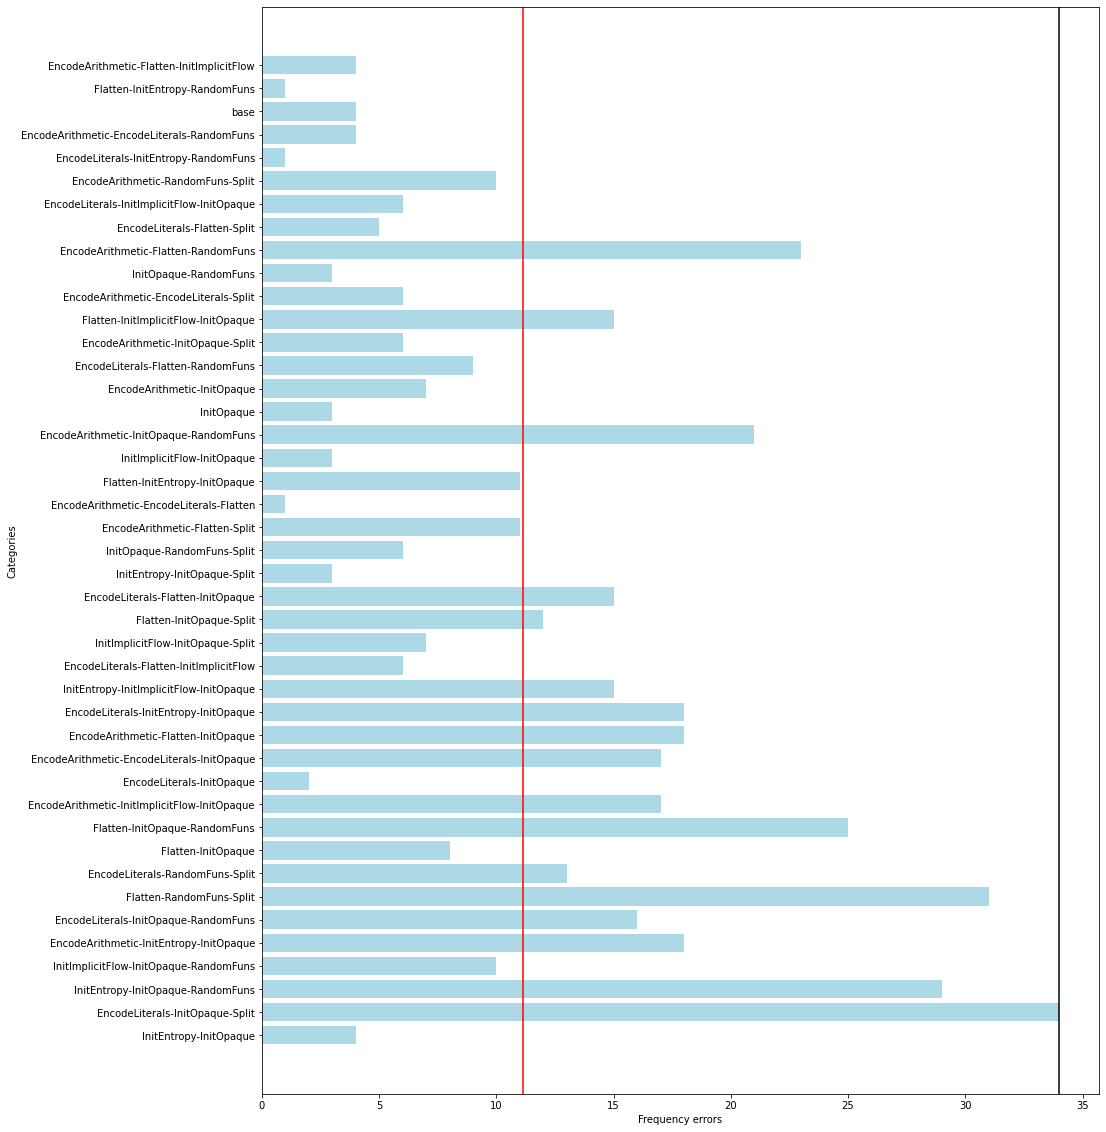

In [32]:
plt.figure(figsize=(15, 20))

plt.barh(list(count_set_obfs.keys()), list(count_set_obfs.values()), color="lightblue")

plt.axvline(np.asarray(list(count_set_obfs.values())).mean(), color="red") # Horizontal line adding the threshold
#plt.axvline(np.asarray(list(count_set_obfs.values())).std(), color="grey") # Horizontal line adding the threshold
plt.axvline(np.asarray(list(count_set_obfs.values())).max(), color="black") # Horizontal line adding the threshold

plt.xlabel("Frequency errors") # x label
plt.ylabel("Categories") # y label
plt.show()

In [33]:
#Ordina e ritorna una lista
ordered_set_obfs = count_set_obfs.most_common()
for elem in ordered_set_obfs:
  print(elem)

('EncodeLiterals-InitOpaque-Split', 34)
('Flatten-RandomFuns-Split', 31)
('InitEntropy-InitOpaque-RandomFuns', 29)
('Flatten-InitOpaque-RandomFuns', 25)
('EncodeArithmetic-Flatten-RandomFuns', 23)
('EncodeArithmetic-InitOpaque-RandomFuns', 21)
('EncodeArithmetic-InitEntropy-InitOpaque', 18)
('EncodeArithmetic-Flatten-InitOpaque', 18)
('EncodeLiterals-InitEntropy-InitOpaque', 18)
('EncodeArithmetic-InitImplicitFlow-InitOpaque', 17)
('EncodeArithmetic-EncodeLiterals-InitOpaque', 17)
('EncodeLiterals-InitOpaque-RandomFuns', 16)
('InitEntropy-InitImplicitFlow-InitOpaque', 15)
('EncodeLiterals-Flatten-InitOpaque', 15)
('Flatten-InitImplicitFlow-InitOpaque', 15)
('EncodeLiterals-RandomFuns-Split', 13)
('Flatten-InitOpaque-Split', 12)
('EncodeArithmetic-Flatten-Split', 11)
('Flatten-InitEntropy-InitOpaque', 11)
('InitImplicitFlow-InitOpaque-RandomFuns', 10)
('EncodeArithmetic-RandomFuns-Split', 10)
('EncodeLiterals-Flatten-RandomFuns', 9)
('Flatten-InitOpaque', 8)
('InitImplicitFlow-InitOpaqu

### **Stampa per etichetta erronea**

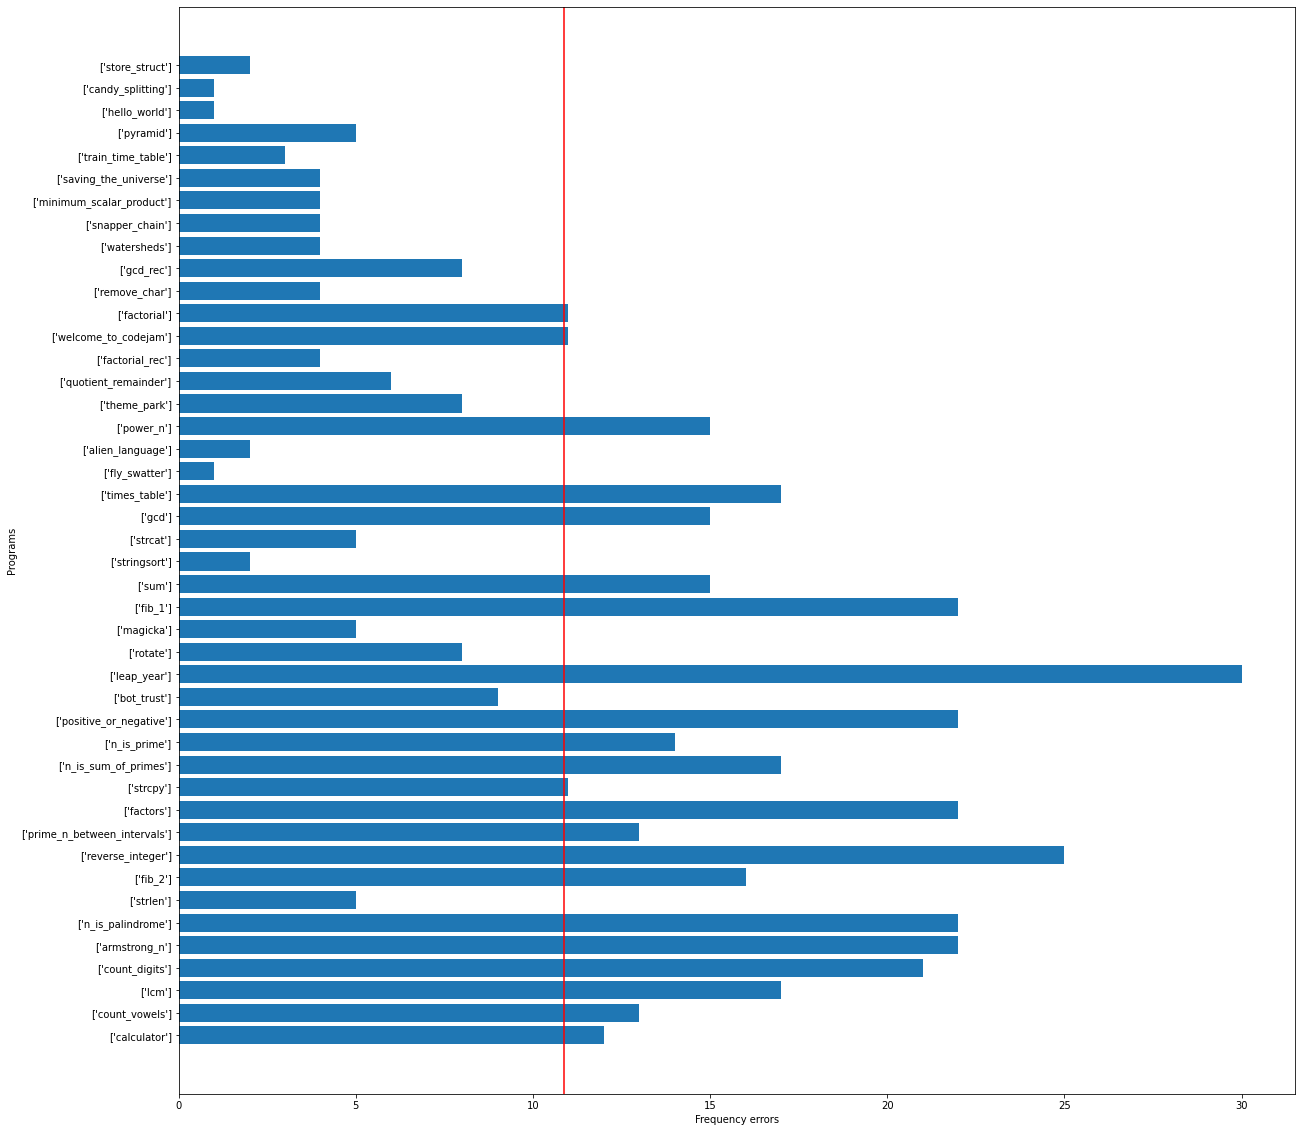

In [34]:
plt.figure(figsize=(20, 20))
plt.axvline(np.asarray(list(count_labels_err.values())).mean(), color="red") # Horizontal line adding the threshold
plt.barh(list(count_labels_err.keys()), list(count_labels_err.values()))

plt.xlabel("Frequency errors") # x label
plt.ylabel("Programs") # y label
plt.show()

###Stampa per singolo offuscamento erroneo

Non tutti gli offuscamenti sono applicati lo stesso numero di volte, quindi il grafico non ha fedeltà (la trasformazione X può essere applicata 10 volte e fallire 9, mentre la trasformazione Y può essere applicata 30 volte e fallire 10, il grafo rappresenta gli errori unitari e non in percentuale d'applicazione).

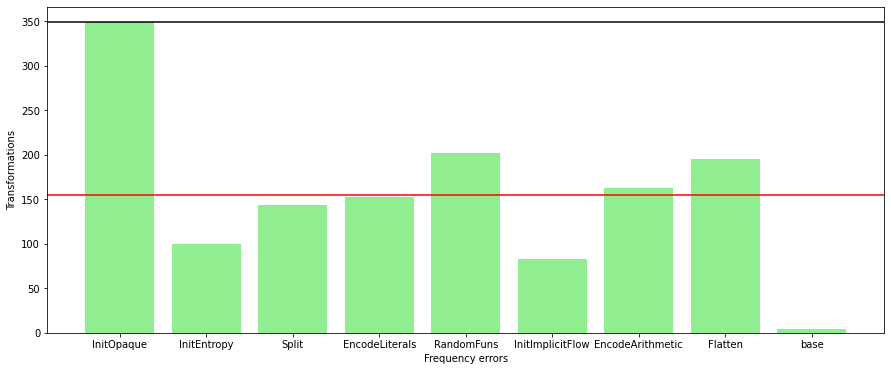

In [35]:
#count_single_obf_dict = dict(count_single_obf)

plt.figure(figsize=(15, 6))
plt.bar(list(count_single_obf.keys()), list(count_single_obf.values()), color="lightgreen")
plt.axhline(np.asarray(list(count_single_obf.values())).mean(), color="red") # Horizontal line adding the threshold
#plt.axhline(np.asarray(list(count_single_obf.values())).std(), color="grey") # Horizontal line adding the threshold
plt.axhline(np.asarray(list(count_single_obf.values())).max(), color="black") # Horizontal line adding the threshold
plt.xlabel("Frequency errors") # x label
plt.ylabel("Transformations") # y label
plt.show()